In [ ]:
#(1)Copy Dataset
from google.colab import drive
import os

drive.mount('/content/drive')

#Konfigurasi Path
source = '/content/drive/MyDrive/Colab Notebooks/dataset'
dest = '/content/dataset'

if os.path.exists(source):
    print(f"Menyalin data dari {source}")
    !cp -r "$source" "$dest"

    if os.path.exists(dest):
        print(f"Isi folder dataset: {os.listdir(dest)}")
else:
    print(f"Error")

Mounted at /content/drive
Menyalin data dari /content/drive/MyDrive/Colab Notebooks/dataset
Isi folder dataset: ['LyricsWav', 'readme.txt', 'UnvoicedFrameLabel', 'UndividedWavfile', 'Lyrics', 'Wavfile', 'PitchLabel', 'vocal-nonvocalLabel']


In [ ]:
#(2)Untuk menentukan target foldernya yang benar yaitu Wavfile dan PitchLabel
import glob

base_dataset_path = '/content/dataset'
target_wav_dir = os.path.join(base_dataset_path, 'Wavfile')
target_label_dir = os.path.join(base_dataset_path, 'PitchLabel')

print(f"Target Audio Folder: {target_wav_dir}")
if os.path.exists(target_wav_dir):
    wav_files = glob.glob(os.path.join(target_wav_dir, "*.wav"))
    print(f"Jumlah file audio : {len(wav_files)}")

print(f"Contoh file: {os.path.basename(wav_files[0])}")
wav_dir = target_wav_dir
label_dir = target_label_dir

Target Audio Folder: /content/dataset/Wavfile
Jumlah file audio : 1000
Contoh file: bug_3_05.wav


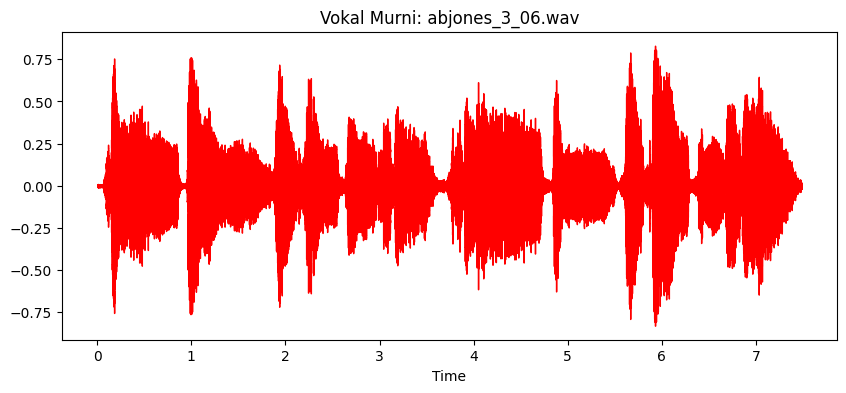

In [ ]:
#(3)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

#ambil 1 file contoh
example_file = wav_files[2]

#Load (Stereo)
y, sr = librosa.load(example_file, sr=16000, mono=False)

#Pisahkan Channel (0: Musik, 1: Vokal)
vocal_audio = y[1]

#Tampilkan
plt.figure(figsize=(10, 4))
librosa.display.waveshow(vocal_audio, sr=sr, color='red')
plt.title(f"Vokal Murni: {os.path.basename(example_file)}")
plt.show()

#Play
ipd.Audio(vocal_audio, rate=sr)

In [ ]:
#(4)
#Fungsi Matematika Konversi Hz <-> Bins
import numpy as np

#CREPE Architecture
CENTS_PER_BIN = 20  #Setiap bin mewakili 20 cents (sangat presisi)
PITCH_BINS = 360    #Total kelas output(C1 - B7)

#Rumus: 1200 * log2(f / 10)
def to_local_average_cents(frequency): #Mengubah Hz menjadi Cents relative terhadap 10Hz.
    if frequency == 0:
        return 0
    return 1200 * np.log2(frequency / 10.0)  #pakai logaritma basis 2 karena musik bersifat logaritmik()

def get_bin_index(frequency): #Mengubah Hz menjadi index Bin (0 - 359).
    if frequency <= 0:
        return 0 # Bin 0 untuk silence/unvoiced

    cents = to_local_average_cents(frequency) #hitung cents
    bin_idx = int(np.round(cents / CENTS_PER_BIN))#masukkan ke bin()

    #Clip agar tidak keluar batas idx (0 sampai 359)
    return np.clip(bin_idx, 0, PITCH_BINS - 1)

print(f"Contoh: Nada A4 (440Hz) masuk ke Bin nomor: {get_bin_index(440)}")

Contoh: Nada A4 (440Hz) masuk ke Bin nomor: 328


In [ ]:
#cents itu seperti contoh jarak dari nada C ke C# seperti 1meter, terlalu jauh untuk mengukur fales
#atau nada yang meleset sedikit. Jadi centsnya dari 1 meter = 100 cm, memecah 1 nada(100cents) menjadi
#5 loker yang kecil dimana per lokernya itu 20 cents. Untuk mengukur ketepatan nada. Kalau suara melesetnya
#+10 cents berarti sedikit tinggi dari nada aslinya(sharp), tapi belum sampai jadi nada C#

#Bin = seperti 360 loker. Potong potong range frekuensi suara menjadi 360 bagian.
#untuk menebak masuk ke loker yang no. berapa?
#1 loker(bin) = 20 cents

#jadinya modelnya bisa mendeteksi nada dengan 5x lebih teliti daripada tuner biasa.

#pakai Log Basis 2 (log2) karena basis perubahannya adalah angka 2 (Setiap naik oktaf = frekuensi * 2).
#Logaritma bertugas "meratakan" grafik yang melengkung tajam (eksponensial) menjadi garis lurus (linear) supaya mudah dihitung oleh komputer.
#tanpa Log: 110, 220, 440, 880(Jaraknya berantakan) ; dengan Log2: 1, 2, 3, 4 (Jaraknya rapi, masing-masing 1 oktaf)

In [ ]:
#(5)
#Main Preprocessing Loop
import numpy as np

wav_dir = '/content/dataset/Wavfile'
label_dir = '/content/dataset/PitchLabel'

print(f"Target Audio: {wav_dir}")
print(f"Target Label: {label_dir}")

X_data = [] # Audio chunks(wadah untuk potongan audio ; input)
y_data = [] # Label bins(wadah untuk label nada ; kunci jawabannya)

#Cari semua file wav
wav_files = glob.glob(os.path.join(wav_dir, "*.wav"))
print(f"Total file ditemukan: {len(wav_files)}")

# Konstanta Model
FRAME_SIZE = 1024 #setiap potongan audio panjangnya 1024 samples.
HOP_SIZE = 160    # windownya bergeser setiap (sekitar 10ms).
sr_target = 16000 # Sample rate wajib

count = 0
matches_found = 0

for wav_file in wav_files:
    filename = os.path.basename(wav_file)
    file_id = filename.split('.')[0]

    #Cari file label pasangannya (.pv)
    label_file = os.path.join(label_dir, file_id + ".pv")

    #Cek case sensitive (jaga-jaga kalau ada .PV)
    if not os.path.exists(label_file):
        label_file = os.path.join(label_dir, file_id + ".PV")

    #tidak ketemu, skip
    if not os.path.exists(label_file):
        print(f"Skip: Label untuk {filename} tidak ditemukan.")
        continue

    matches_found += 1

    #Load Audio (Vokal Saja - Channel 1)
    try:
        y, sr = librosa.load(wav_file, sr=sr_target, mono=False) #load audio didalam Stereo(2 channel)
        vocal = y[1] # Ambil channel kanan (Vokal)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    #Load Label
    try:
        with open(label_file, 'r') as f:
            freqs = [float(line.strip()) for line in f.readlines()]
    except:
        continue

    #Slicing Loop
    n_frames = len(freqs)

    for i in range(n_frames):
        start_sample = i * HOP_SIZE
        end_sample = start_sample + FRAME_SIZE

        #memastikan tidak out of bounds
        if end_sample > len(vocal):
            break

        current_freq = freqs[i]

        #FILTER: Hanya ambil frame yang bersuara (freq > 0)
        #buang frame diam (unvoiced) agar model fokus belajar nada
        if current_freq > 0:
            audio_chunk = vocal[start_sample:end_sample]

            #Normalisasi sederhana ; membuat volume suaranya seragam(-1 sampai 1)
            max_val = np.max(np.abs(audio_chunk))
            if max_val > 0:
                audio_chunk = audio_chunk / max_val

            #Convert Freq ke Bin Index
            bin_label = get_bin_index(current_freq)

            X_data.append(audio_chunk)
            y_data.append(bin_label)

    count += 1
    if count % 50 == 0:
        print(f"Processed {count}/{len(wav_files)} songs...", end='\r')

#Convert ke Numpy
X_data = np.array(X_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.longlong)

print(f"File cocok ditemukan: {matches_found} dari {len(wav_files)}")
print(f"Total Sampel Training (Frames): {X_data.shape[0]}")
print(f"Shape X: {X_data.shape}")

Target Audio: /content/dataset/Wavfile
Target Label: /content/dataset/PitchLabel
Total file ditemukan: 1000
File cocok ditemukan: 1000 dari 1000
Total Sampel Training (Frames): 280400
Shape X: (280400, 1024)


In [ ]:
#(6) Simpan Data hasil preprocessingnya
save_path = '/content/drive/MyDrive/DeepLearning_Project/processed_data'
if not os.path.exists(save_path):
    os.makedirs(save_path)

print(f"Menyimpan data ke G Drive: {save_path}")
np.save(os.path.join(save_path, 'X_train.npy'), X_data)
np.save(os.path.join(save_path, 'y_train.npy'), y_data)

Menyimpan data ke G Drive: /content/drive/MyDrive/DeepLearning_Project/processed_data


In [ ]:
#(1.1)
##Load Dataset Langsung dari Drive
#(untuk shortcut supaya setiap membuka atau me restart runtime dan melanjutkan codenya di colab tidak perlu mengulang proses preprocessing
#(memotong audio, convert ke spectrogram, dll) yang memakan waktu lama. Jadi cukup memanggil hasil olahan yang sudah disimpan ("Save Data") sebelumnya.
from google.colab import drive #import modul khusus milik Google Colab untuk menghubungkan (mount) penyimpanan cloud Google Drive ke dalam sistem file Linux di Colab.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import os

#Connect Drive(supaya Colab boleh membaca dan menulis file di acc Google Drive))
drive.mount('/content/drive')

#Load Data Numpy(dataset yang sudah matang)
save_path = '/content/drive/MyDrive/DeepLearning_Project/processed_data'
X_data = np.load(os.path.join(save_path, 'X_train.npy'))
y_data = np.load(os.path.join(save_path, 'y_train.npy'))
#membaca file dari hardisk Drive dan memasukkannya ke RAM (X_data dan y_data).
#Menggabungkan alamat folder dengan nama file (X_train.npy) secara otomatis.

print(f"Data Loaded: {X_data.shape[0]} samples.")
if os.path.exists(save_path):
    print(f"Folder ditemukan: {save_path}")
    print("Isi folder:", os.listdir(save_path))
else:
    print(f"ERROR")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Loaded: 280400 samples.
Folder ditemukan: /content/drive/MyDrive/DeepLearning_Project/processed_data
Isi folder: ['X_train.npy', 'y_train.npy']


In [ ]:
#(7) Setup Dataset & DataLoader (DENGAN AUGMENTASI)
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training akan berjalan di: {device}")

#DEFINISI CUSTOM DATASET
class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=False):
        #Ubah ke Tensor tapi biarkan di CPU dulu (biar hemat GPU memory)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        audio = self.X[idx]
        label = self.y[idx]

        #Logika Augmentasi: Hanya jalan jika augment=True (Training)
        if self.augment:
            # A. White Noise (Gangguan kresek-kresek)
            # 50% peluang data akan diberi noise
            if torch.rand(1).item() > 0.5:
                #Level noise 0.005 (kecil tapi cukup untuk bikin model mikir)
                noise = torch.randn_like(audio) * 0.005
                audio = audio + noise

            #Volume Gain (Suara pelan/keras)
            #50% peluang volume akan diubah
            if torch.rand(1).item() > 0.5:
                #Random gain antara 0.8x (pelan) sampai 1.2x (keras)
                gain = torch.rand(1).item() * 0.4 + 0.8
                audio = audio * gain

        #Tambah dimensi channel (1, 1024) supaya bisa masuk ke CNN
        if audio.dim() == 1:
            audio = audio.unsqueeze(0)

        return audio, label

#SPLIT DATA
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

#BUAT DATASET & DATALOADER
BATCH_SIZE = 128

#augment=True HANYA untuk Training
#Validasi (Ujian) harus bersih tanpa noise.
train_dataset = AugmentedDataset(X_train, y_train, augment=True)
val_dataset = AugmentedDataset(X_val, y_val, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Set: {len(train_dataset)} sampel (Dengan Noise Augmentation)")
print(f"Validation Set: {len(val_dataset)} sampel (Bersih)")

Training akan berjalan di: cuda
Training Set: 224320 sampel (Dengan Noise Augmentation)
Validation Set: 56080 sampel (Bersih)


In [ ]:
#(8)
#Definisi Model CNN (VocalTuna) ; menggunakan 1D CNN(One Dimensional CNN)
import torch.nn as nn

class VocalTunaNet(nn.Module):
    def __init__(self):
        super(VocalTunaNet, self).__init__()
        #1.Feature Extractor (Convolutional Layers)
        #Input: [Batch, 1, 1024]

        # Layer 1: Menangkap fitur dasar gelombang(Output Channel: 128 (Model membuat 128 filter berbeda untuk melihat audio dari berbagai sudut pandang))
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=51, stride=4, padding=25),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 2: Menangkap pola yang lebih kompleks(input : 128 ; output : 128)
        #memperdalam pemahaman fitur yang didapat dari Layer 1.
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 3 (output : 256)
        #Semakin dalam layernya, ukuran data makin pendek (karena MaxPool), tapi fiturnya makin tebal (banyak channel) karena model mempelajari pola yang lebih kompleks/abstrak.
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        #Layer 4 (output : 512)
        #layer ekstraksi fitur terakhir. data sudah sangat terkompresi tapi sangat kaya informasi.
        self.conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=51, stride=1, padding=25),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        #Tugasnya menerima audio mentah dan mengubahnya menjadi fitur-fitur penting (pola gelombang, tekstur suara, frekuensi dominan).

        #2.Classifier (Fully Connected)
        #mengambil fitur dari feature extractor tadi, lalu menebak: "Ini masuk ke nada (Bin) nomor berapa dari 0 sampai 359?"
        # Setelah Conv4 dan MaxPool, dimensi data menjadi [Batch, 512, 16] (kira-kira)
        #flatten menjadi satu vektor panjang (8192 features) dan merangkumnya menjadi 360 angka.
        self.fc = nn.Linear(512 * 16, 360) # 360 Output Bins ; Angka tertinggi adalah tebakan modelnya.

        #Dropout untuk mencegah overfitting
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        #Flatten
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc(x)
        return x

#Inisialisasi Modelnya
model = VocalTunaNet().to(device)
print(model)

VocalTunaNet(
  (conv1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(51,), stride=(4,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 128, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(5

In [ ]:
#untuk bagian Classifier : (input : 1024 -> layer1 (/4) -> 256 ->layer1(/2) -> 128 ->layer2 (/2) -> 64 ->layer3 (/2) -> 32 ->layer4(/2) -> 16)
#output akhir CNN modelnya, ukurannya adalah 512 Channel * 16 Panjang Data.

In [ ]:
#(9)
#(Relaxed Accuracy)
import torch

def check_relaxed_accuracy(loader, model, tolerance=3):
    model.eval() # Mode Ujian (Matikan Dropout)
    correct = 0
    total = 0

    with torch.no_grad(): # Jangan hitung gradien (hemat memori)
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            #Hitung selisih tebakan vs kunci jawaban
            diff = torch.abs(predicted - labels)

            #kalau selisih <= toleransi, anggap benar
            correct += (diff <= tolerance).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [ ]:
#Menghitung akurasi dengan toleransi.
#kalau tebakan model meleset <= 3 bin (±50 cents), tetap dianggap BENAR. karena dalam musik, sedikit meleset (fales tipis) masih bisa dimaklumi.

In [ ]:
#(10) Training Loop Final
import torch.optim as optim

#Setup
criterion = nn.CrossEntropyLoss() # Loss untuk klasifikasi
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)#Kecepatan belajar
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

EPOCHS = 50
best_acc = 0.0

history = {'loss': [], 'accuracy': []}

for epoch in range(EPOCHS):
    model.train() #Mode latihan atau belajar
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Pindahkan data dari CPU ke GPU saat mau dipakai
        optimizer.zero_grad() #Reset gradien ; catatan error sebelumnya
        outputs = model(inputs) #Forward pass(menebak)
        loss = criterion(outputs, labels) #Hitung Error

        #Proses Belajar (Backpropagation)
        loss.backward() #Backpropagation(evaluasi)
        optimizer.step() #Update bobotnya, otaknya(optimization)

        running_loss += loss.item()

        #hitung Akurasi Training(Strict) untuk monitoring
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    #fase validation(mode ujian)
    val_acc = check_relaxed_accuracy(val_loader, model, tolerance=3)
    scheduler.step(val_acc)

    history['loss'].append(avg_train_loss)
    history['accuracy'].append(val_acc)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")

    #Save modelnya
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DeepLearning_Project/vocal_tuna_best.pth')
        print("Model Saved!")

print(f"Best Validation Accuracy: {best_acc:.2f}%")

Epoch [1/50] | Loss: 3.3909 | Train Acc: 7.23% | Val Acc: 40.98% | LR: 0.001000
Model Saved!
Epoch [2/50] | Loss: 3.2838 | Train Acc: 8.19% | Val Acc: 42.67% | LR: 0.001000
Model Saved!
Epoch [3/50] | Loss: 3.2613 | Train Acc: 8.52% | Val Acc: 43.57% | LR: 0.001000
Model Saved!
Epoch [4/50] | Loss: 3.2280 | Train Acc: 9.02% | Val Acc: 43.42% | LR: 0.001000
Epoch [5/50] | Loss: 3.1954 | Train Acc: 9.47% | Val Acc: 40.65% | LR: 0.001000
Epoch [6/50] | Loss: 3.1691 | Train Acc: 10.06% | Val Acc: 43.93% | LR: 0.001000
Model Saved!
Epoch [7/50] | Loss: 3.1434 | Train Acc: 10.52% | Val Acc: 45.17% | LR: 0.001000
Model Saved!
Epoch [8/50] | Loss: 3.1187 | Train Acc: 11.09% | Val Acc: 45.56% | LR: 0.001000
Model Saved!
Epoch [9/50] | Loss: 3.0917 | Train Acc: 11.60% | Val Acc: 44.83% | LR: 0.001000
Epoch [10/50] | Loss: 3.0624 | Train Acc: 12.24% | Val Acc: 46.64% | LR: 0.001000
Model Saved!
Epoch [11/50] | Loss: 3.0282 | Train Acc: 13.08% | Val Acc: 48.29% | LR: 0.001000
Model Saved!
Epoch [1

In [ ]:
#Lanjut Training (Epoch 51 - 80)
import torch
import torch.optim as optim
import time

#LOAD MODEL TERBAIK DARI SESI SEBELUMNYA
try:
    best_model_path = '/content/drive/MyDrive/DeepLearning_Project/vocal_tuna_best.pth'
    model.load_state_dict(torch.load(best_model_path, map_location=device))
except Exception as e:
    print(f"Gagal load model ({e}).")

#SETUP OPTIMIZER BARU (Fine-Tuning) ---
# Kita turunkan Learning Rate sedikit (dari 0.001 ke 0.0005)
# Alasannya: Model sudah lumayan pintar, jadi belajarnya harus lebih pelan/hati-hati.
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Scheduler tetap dipakai
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# --- 3. SETUP LOOP LANJUTAN ---
START_EPOCH = 50
END_EPOCH = 90

# Pastikan history ada (jika variabel hilang karena restart runtime)
if 'history' not in locals():
    history = {'loss': [], 'accuracy': []}

# Pastikan best_acc mengambil nilai terakhir (jika hilang, reset ke 0 atau nilai manual)
if 'best_acc' not in locals():
    best_acc = 0.0

for epoch in range(START_EPOCH, END_EPOCH):
    start_time = time.time()

    # --- TRAINING ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Pindahkan ke GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Hitung Akurasi Training
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # --- VALIDASI ---
    val_acc = check_relaxed_accuracy(val_loader, model, tolerance=3)

    # Update Scheduler
    scheduler.step(val_acc)

    # Simpan History (Append ke list yang sudah ada)
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    duration = time.time() - start_time

    print(f"Ep {epoch+1}/{END_EPOCH} | Loss: {avg_train_loss:.4f} | Trn Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | LR: {current_lr:.6f} | {duration:.1f}s")

    # Save Model (Hanya jika mengalahkan rekor sebelumnya)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DeepLearning_Project/vocal_tuna_best.pth')
        print("Model Saved!")

print(f"Best Validation Accuracy: {best_acc:.2f}%")

Ep 51/90 | Loss: 1.7119 | Trn Acc: 47.20% | Val Acc: 66.25% | LR: 0.000500 | 184.4s
Model Saved!
Ep 52/90 | Loss: 1.6341 | Trn Acc: 49.39% | Val Acc: 66.56% | LR: 0.000500 | 183.2s
Model Saved!
Ep 53/90 | Loss: 1.6033 | Trn Acc: 50.37% | Val Acc: 66.64% | LR: 0.000500 | 184.7s
Model Saved!
Ep 54/90 | Loss: 1.5828 | Trn Acc: 50.92% | Val Acc: 66.76% | LR: 0.000500 | 182.8s
Model Saved!
Ep 55/90 | Loss: 1.5604 | Trn Acc: 51.62% | Val Acc: 66.81% | LR: 0.000500 | 183.0s
Model Saved!
Ep 56/90 | Loss: 1.5478 | Trn Acc: 51.87% | Val Acc: 66.74% | LR: 0.000500 | 183.1s
Ep 57/90 | Loss: 1.5366 | Trn Acc: 52.19% | Val Acc: 66.60% | LR: 0.000500 | 183.1s
Ep 58/90 | Loss: 1.5275 | Trn Acc: 52.48% | Val Acc: 66.35% | LR: 0.000500 | 183.0s
Ep 59/90 | Loss: 1.5150 | Trn Acc: 52.83% | Val Acc: 66.67% | LR: 0.000500 | 182.8s
Ep 60/90 | Loss: 1.5082 | Trn Acc: 53.00% | Val Acc: 67.12% | LR: 0.000500 | 182.8s
Model Saved!
Ep 61/90 | Loss: 1.5011 | Trn Acc: 53.08% | Val Acc: 66.44% | LR: 0.000500 | 182.7

In [ ]:
# Conclusion of Experiment :

#This experiment utilized data augmentation (Random Noise & Volume Scaling).
#Result: The best validation accuracy achieved was 69.24%.
#Analysis: This is lower than the baseline model (74.39%). The lightweight architecture struggled to generalize on the noisy data.
#Decision: This model was discarded and not used for deployment.